<a href="https://colab.research.google.com/github/01-vyom/Machine-Learning-Projects/blob/master/Kaggle/%20House%20Prices%3A%20Advanced%20Regression%20Techniques/Simple_House_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Import And Load Data
import numpy as np # For numerical fast numerical calculations
import matplotlib.pyplot as plt # For making plots
import pandas as pd # Deals with data
import seaborn as sns # Makes beautiful plots
from sklearn.preprocessing import StandardScaler # Testing sklearn
import tensorflow as tf # Imports tensorflow
from sklearn import metrics
import keras # Imports keras
from tensorflow.python.data import Dataset
import math
tf.logging.set_verbosity(tf.logging.ERROR)

Ames_House_data = pd.read_csv("/content/drive/My Drive/House Price Prediction/train.csv")
#Ames_House_data = Ames_House_data.reindex(
 #   np.random.permutation(Ames_House_data.index))

Using TensorFlow backend.


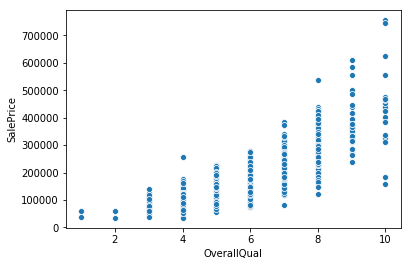

In [0]:
 sns.scatterplot(x=Ames_House_data["OverallQual"],y=Ames_House_data["SalePrice"])

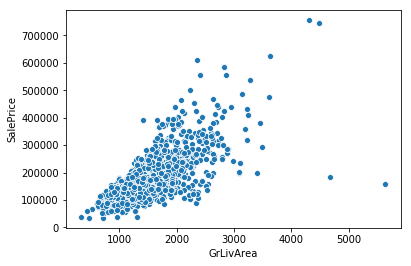

In [0]:
 sns.scatterplot(x=Ames_House_data["GrLivArea"],y=Ames_House_data["SalePrice"])

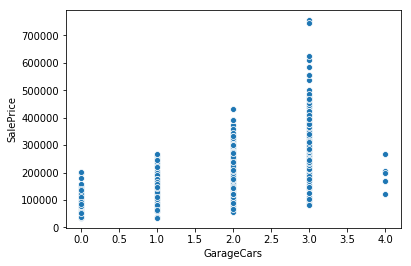

In [0]:
 sns.scatterplot(x=Ames_House_data["GarageCars"],y=Ames_House_data["SalePrice"])

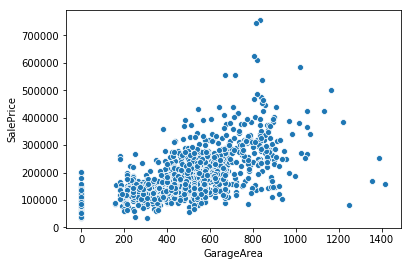

In [0]:
 sns.scatterplot(x=Ames_House_data["GarageArea"],y=Ames_House_data["SalePrice"])

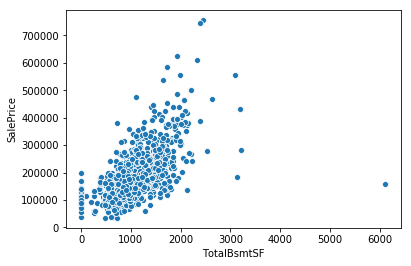

In [0]:
 sns.scatterplot(x=Ames_House_data["TotalBsmtSF"],y=Ames_House_data["SalePrice"])

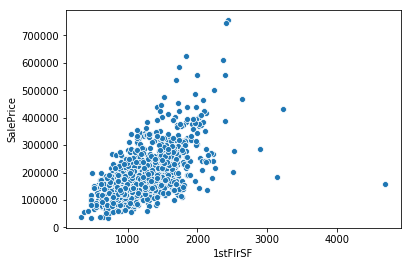

In [0]:
 sns.scatterplot(x=Ames_House_data["1stFlrSF"],y=Ames_House_data["SalePrice"])

In [0]:
def preprocess_features(Ames_House_data):
  selected_features = Ames_House_data[
    ["LotArea"
    ]]
    #Mean Normalization
  selected_features["LotArea"]=((np.log2(selected_features["LotArea"])-13.1)/(0.7))
  processed_features = selected_features.copy()
  return processed_features

#define output features
def preprocess_targets(Ames_House_data):
  output_targets = pd.DataFrame()
  output_targets["SalePrice"] = (
    Ames_House_data["SalePrice"])
  output_targets["SalePrice"] = (output_targets["SalePrice"]/100)
  return output_targets

In [0]:
training = preprocess_features(Ames_House_data)
training_examples = training.head(1022)
training_examples.describe()
test_examples = training.tail(438)

training_targ = preprocess_targets(Ames_House_data)
training_targets =training_targ.head(1022)
test_targets=training_targ.tail(438)
training_targets.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SalePrice
count,1022.000000
mean,1817.132544
std,798.546633
min,349.000000
25%,1300.000000
50%,1637.450000
75%,2149.750000
max,7550.000000


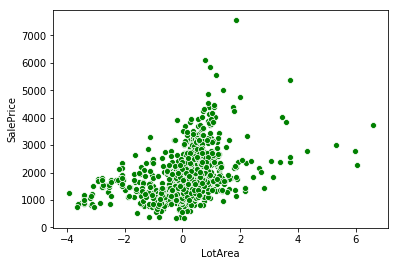

In [0]:
sns.scatterplot(x=training_examples["LotArea"],y=training_targets["SalePrice"],color="g")

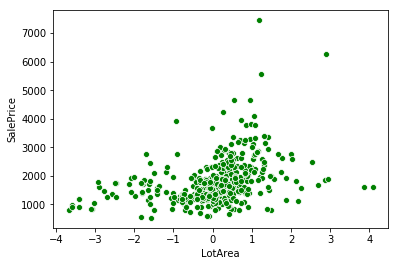

In [0]:
sns.scatterplot(x=test_examples["LotArea"],y=test_targets["SalePrice"],color="g")

In [0]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):

    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets):
  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["SalePrice"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["SalePrice"], 
      num_epochs=1, 
      shuffle=False)
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    
    # Compute trainingloss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.legend()

  return linear_regressor

In [0]:
training_examples.describe()
#print(type(training_examples))

,LotArea
count,1022.000000
mean,0.067180
std,1.072570
min,-3.936720
25%,-0.314813
50%,0.151788
75%,0.580351
max,6.593743


In [0]:
training_targets.describe()

#print(type(training_targets))

,SalePrice
count,1022.000000
mean,1817.132544
std,798.546633
min,349.000000
25%,1300.000000
50%,1637.450000
75%,2149.750000
max,7550.000000


Training model...
RMSE (on training data):
  period 00 : 1709.47
  period 01 : 1446.96
  period 02 : 1204.49
  period 03 : 992.26
  period 04 : 831.59
  period 05 : 769.60
  period 06 : 746.03
  period 07 : 736.33
  period 08 : 735.30
  period 09 : 733.21
Model training finished.


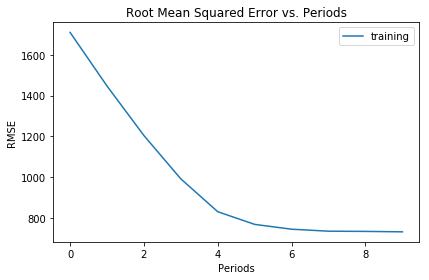

In [0]:
linear_regressor = train_model(
    learning_rate=0.8,
    steps=800,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets)

In [0]:
def my_input_fn1(features, batch_size=1, shuffle=True, num_epochs=None):  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    # Return the next batch of data.
    features= ds.make_one_shot_iterator().get_next()
    return features

In [0]:

predict_test_input_fn = lambda: my_input_fn1(
      test_examples, 
 #     test_targets["SalePrice"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
#print(type(test_predictions),list(test_predictions),type(list(test_predictions)))
test_predictions2 =np.array([item['predictions'][0] for item in test_predictions])
test_predictions2 =np.array([item['predictions'][0] for item in test_predictions])
x = np.array(test_examples["LotArea"])
y = np.array(test_targets["SalePrice"])
# #print(test_predictions)
# main =[]
# k=1461
# for i in range(len(test_predictions1)):
#   l=[k+i,test_predictions1[i]]
#   main.append(l)
df = pd.DataFrame(test_predictions2)
#sns.distplot(df[1], bins=10, kde=False)
#print(len(main))
# df = pd.DataFrame(main)
# df.to_csv('/content/drive/My Drive/House Price Prediction/submission2.csv', index=False)
#main_np = np.array(main)
#pd.DataFrame(main_np).to_csv("/content/drive/My Drive/House Price Prediction/submission.csv")
#print(main_np)
#root_mean_squared_error = math.sqrt(
    #metrics.mean_squared_error(test_predictions, test_targets))

#print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

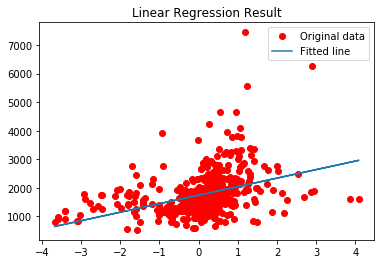

In [0]:
plt.plot(x, y, 'ro', label ='Original data') 
plt.plot(x, test_predictions2, label ='Fitted line') 
plt.title('Linear Regression Result') 
plt.legend() 
plt.show() 

In [0]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


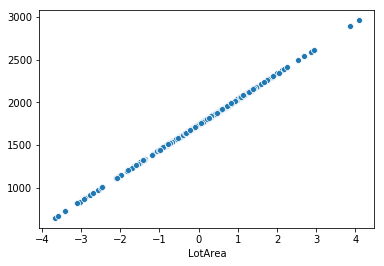

In [0]:
sns.scatterplot(x=test_examples["LotArea"],y=test_predictions2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


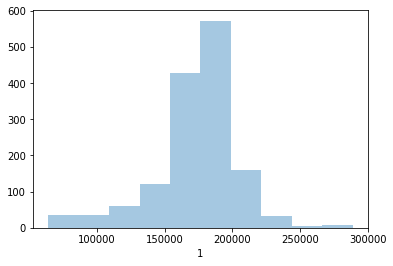

In [0]:
Ames_House_test_data = pd.read_csv("/content/drive/My Drive/House Price Prediction/test.csv")

testf = preprocess_features(Ames_House_test_data)
#test_targets = preprocess_targets(Ames_House_test_data)

predict_test_input_fn = lambda: my_input_fn1(
      testf, 
 #     test_targets["SalePrice"], 
      num_epochs=1, 
      shuffle=False)

testpf = linear_regressor.predict(input_fn=predict_test_input_fn)
#print(type(test_predictions),list(test_predictions),type(list(test_predictions)))
testpf =([item['predictions'][0] for item in testpf])
#print(test_predictions)
main =[]
k=1461
for i in range(len(testpf)):
  l=[k+i,testpf[i]*100]
  main.append(l)
df = pd.DataFrame(main)
sns.distplot(df[1], bins=10, kde=False)
#print(len(main))
# df = pd.DataFrame(main)
#main_np = np.array(main)
#pd.DataFrame(main_np).to_csv("/content/drive/My Drive/House Price Prediction/submission.csv")
#print(main_np)
#root_mean_squared_error = math.sqrt(
    #metrics.mean_squared_error(test_predictions, test_targets))

#print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

In [0]:
df.to_csv('/content/drive/My Drive/House Price Prediction/submission_simple1.csv', index=False)